In [9]:
import xarray as xr
import pandas as pd
import rioxarray as riox
import geopandas as gpd
import contextily as cx

In [10]:
dem = riox.open_rasterio("data/nasadem_sd.tiff").sel(
    band=1
)
dem

<xarray.DataArray (y: 3515, x: 5510)>
[19367650 values with dtype=int16]
Coordinates:
    band         int64 1
  * x            (x) float64 -117.6 -117.6 -117.6 ... -116.1 -116.1 -116.1
  * y            (y) float64 33.51 33.5 33.5 33.5 ... 32.53 32.53 32.53 32.53
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0

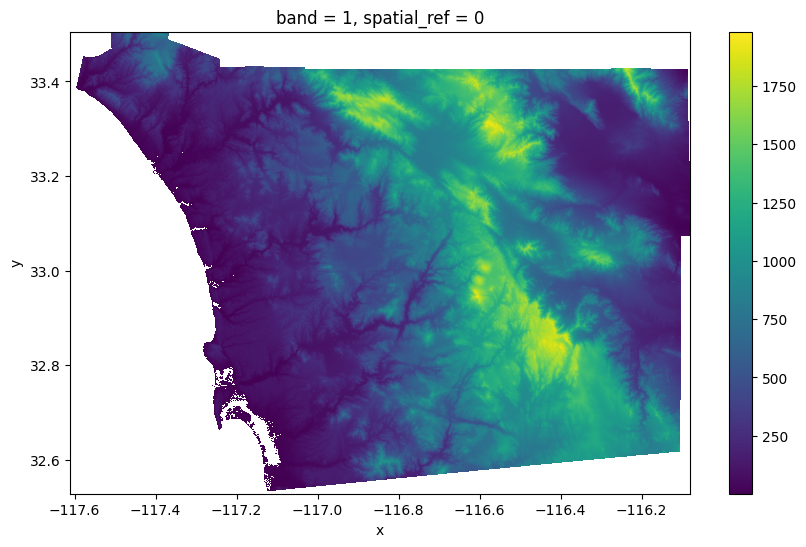

In [12]:
dem.where(dem > 0).plot.imshow(figsize=(10, 6))

In [13]:
# sandeogo neighbourhoods
sandiago_area = gpd.read_file('data/sandiego_tracts.gpkg')
sandiago_area.head()

,GEOID,median_age,total_pop,total_pop_white,tt_work,hh_total,hh_female,total_bachelor,median_hh_income,income_gini,...,state,county,tract,area_sqm,pct_rented,pct_hh_female,pct_bachelor,pct_white,sub_30,geometry
0,06073018300,37.1,2590.0,2375.0,1299.0,2590.0,137.0,0.0,62500.0,0.5355,...,06,073,018300,2.876449,0.373913,0.052896,0.000000,0.916988,False,"POLYGON ((-13069450.120 3922380.770, -13069175..."
1,06073018601,41.2,5147.0,4069.0,1970.0,5147.0,562.0,24.0,88165.0,0.4265,...,06,073,018601,4.548797,0.205144,0.109190,0.004663,0.790558,False,"POLYGON ((-13067719.770 3922939.420, -13067631..."
2,06073017601,54.4,5595.0,4925.0,1702.0,5595.0,442.0,34.0,110804.0,0.4985,...,06,073,017601,8.726275,0.279029,0.078999,0.006077,0.880250,False,"POLYGON ((-13058166.110 3907247.690, -13058140..."
3,06073019301,42.3,7026.0,5625.0,3390.0,7026.0,638.0,46.0,100539.0,0.4003,...,06,073,019301,3.519743,0.196512,0.090806,0.006547,0.800598,False,"POLYGON ((-13056896.290 3925255.610, -13056868..."
4,06073018700,21.8,40402.0,30455.0,24143.0,40402.0,2456.0,23.0,41709.0,0.3196,...,06,073,018700,559.150793,0.949887,0.060789,0.000569,0.753799,False,"POLYGON ((-13090788.510 3946435.430, -13090736..."


<Axes: >

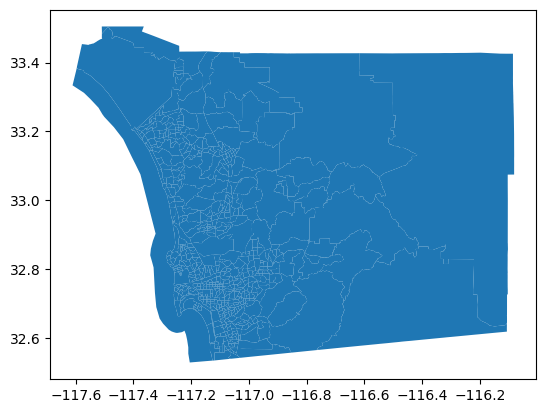

In [14]:
sandiago_area.to_crs('EPSG:4326').plot()

In [15]:
# computing zonal statistics,
# zonal here cane be any geometry like a polygon

largest_tract0 = sandiago_area.query(
    f'area_sqm == {sandiago_area.area_sqm.max()} ')
largest_tract0

,GEOID,median_age,total_pop,total_pop_white,tt_work,hh_total,hh_female,total_bachelor,median_hh_income,income_gini,...,state,county,tract,area_sqm,pct_rented,pct_hh_female,pct_bachelor,pct_white,sub_30,geometry
627,06073021000,60.6,2693.0,2268.0,693.0,2693.0,422.0,35.0,39760.0,0.4416,...,06,073,021000,2759.220497,0.095565,0.156703,0.012997,0.842183,False,"POLYGON ((-12981895.900 3945471.980, -12981872..."


In [24]:
largest_tract0.index[0]

627

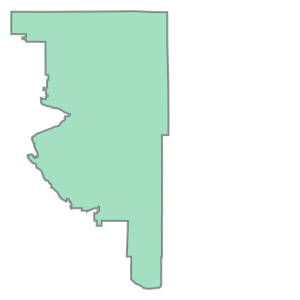

In [16]:
largest_tract = largest_tract0.loc[largest_tract0.index[0], "geometry"]
largest_tract

In [18]:
# Clip the elevation for the largest tract from dem dataset

dem_clip = dem.rio.clip(
    [largest_tract.__geo_interface__], crs=sandiago_area.crs)

In [ ]:
# dem1 = dem.rio.write_crs(sand_area.crs)

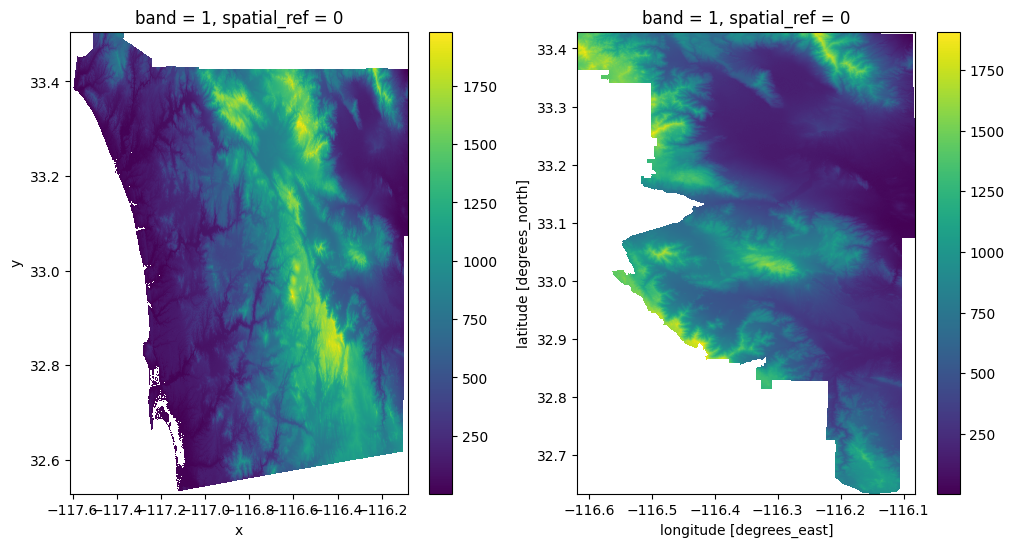

In [19]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
dem.where(dem > 0).plot.imshow(ax=axs[0])


dem_clip.where(dem_clip > 0).plot.imshow(ax=axs[1])

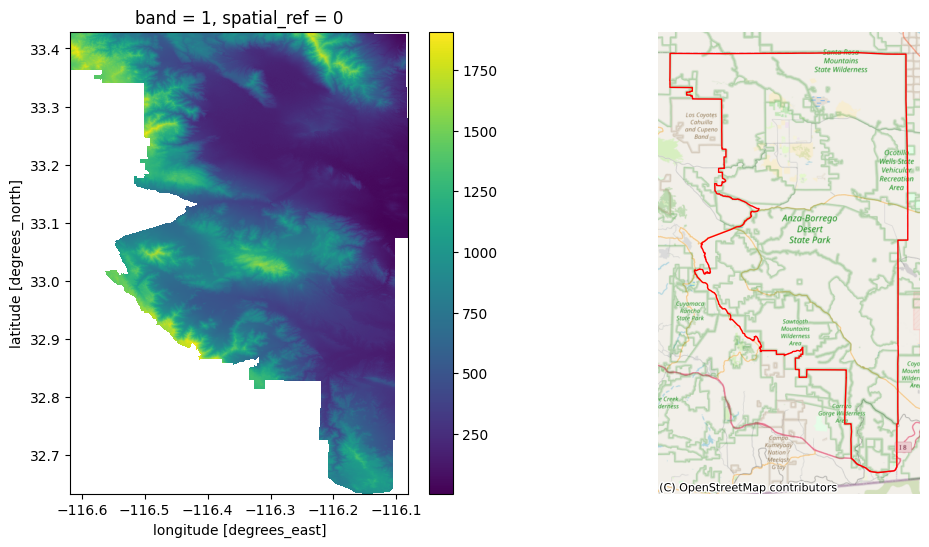

In [20]:
import matplotlib.pyplot as plt
from shapely.geometry import mapping
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


dem_clip.where(dem_clip > 0).plot.imshow(ax=axs[0],)


largest_tract0.plot(
    ax=axs[1], edgecolor="red", facecolor="none")
axs[1].set_axis_off()
cx.add_basemap(
    axs[1], crs=largest_tract0.crs,  source=cx.providers.OpenStreetMap.Mapnik,
)

In [21]:
average_elevation = dem_clip.where(dem_clip > 0).mean()
float(average_elevation)

585.1134643554688

In [22]:
def get_mean_elevation(row, dem):

    # extracting geometry object from gdf
    geom = row['geometry'].__geo_interface__
    dem_clipd = dem.rio.clip([geom], crs=sandiago_area.crs)
    # calculate mean elevation
    elevation = float(dem_clipd.where(dem_clipd > 0).mean())
    return elevation

In [23]:
# this approach can be quite slow in big data
mean_elevation = sandiago_area.apply(get_mean_elevation, dem=dem, axis=1)
mean_elevation

0        7.144268
1       35.648491
2       53.711388
3       91.358780
4      187.312027
          ...    
623    420.549683
624    427.098541
625    639.095886
626    696.880310
627    585.113464
Length: 628, dtype: float64

In [24]:

# A more efficient alternative for our example uses the rasterstats library

from rasterstats import zonal_stats

elevations2 = zonal_stats(
    sandiago_area.to_crs(dem.rio.crs),  # Geotable with zones
    "data/nasadem_sd.tiff",  # Path to surface file
)
elevations2 = pd.DataFrame(elevations2)

In [28]:
elevations2.head()

,min,max,mean,count
0,-12.0,18.0,3.538397,3594
1,-2.0,94.0,35.616395,5709
2,-5.0,121.0,48.742630,10922
3,31.0,149.0,91.358777,4415
4,-32.0,965.0,184.284941,701973


<Axes: >

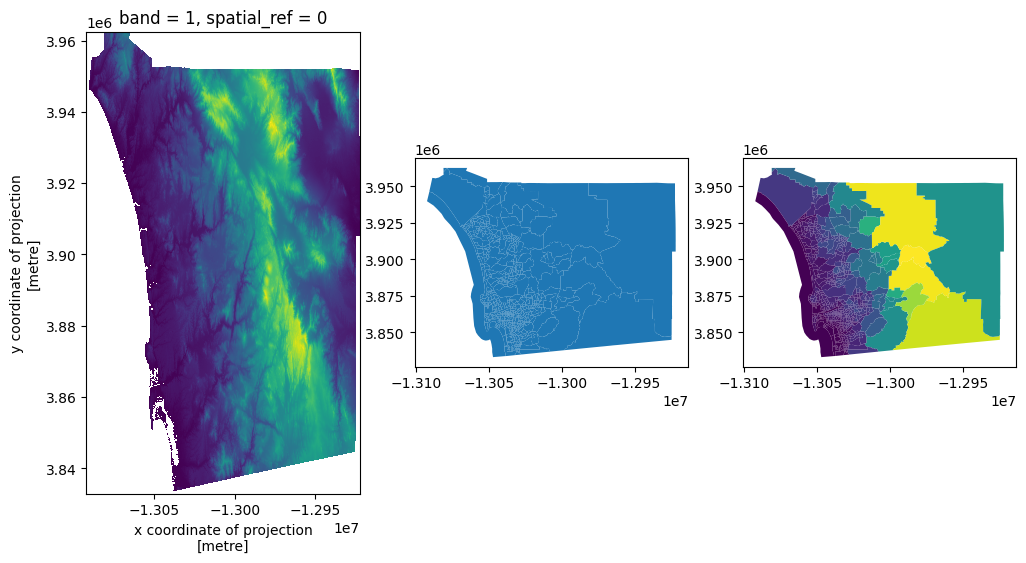

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

dem.where(dem > 0).rio.reproject(sandiago_area.crs).plot.imshow(
    ax=axs[0], add_colorbar=False)

# plot tracts
sandiago_area.plot(ax=axs[1])


# plot elvation on th tract geometry

sandiago_area.assign(elevation=elevations2['mean']).plot(
    'elevation', ax=axs[2])